In [1]:
include("../ToolBox/ToolBox.jl")
import JLD
import FileIO
using .ToolBox
using .Geometry
using Colors

In [2]:
function preprocess3_v1(product_folders, master_view, dem_path, subswath, result_folder, dem_nan,kernel = ones(4,14))
    
    n_coherence = length(product_folders)-1
    dem = 0
    lut1 = 0
    lut2 = 0
    lut_status = [false,false]
    precise_orbit = 0
    master_data = 0
    lines = 0
    samples = 0
    
    stride_line = floor(Int,size(kernel)[1]/2)
    stride_sample = floor(Int,size(kernel)[2]/2)
    
    pod_paths = [Load.pod_path(folder) for folder in product_folders]
    
    for polarization in ["VV","VH"]
        
        println(polarization)
        file_paths = [Load.slc_paths(folder, polarization, subswath) for folder in product_folders]
        meta = [Load.slc_meta(path[2]) for path in file_paths]
        calibration = [Load.slc_calibration(file_paths[i][3],meta[i]["t_0"]) 
                                    for i in 1:length(product_folders)];
        # load pod
        if precise_orbit == 0
            println("load POD")
            precise_orbit = [Load.precise_orbit(pod_paths[i],meta[i]["t_0"]) 
                                    for i in 1:length(product_folders)]
        end
        
        # load DEM
        if dem == 0
            println("load DEM")
            pad = 0.1
            dem = JLD.load(dem_path);
            footprint = SlcUtil.footprint(meta[2], master_view)
            latlon_window = ((minimum(footprint[1]), maximum(footprint[1])), (minimum(footprint[2]), maximum(footprint[2])))
            idx1 =(latlon_window[1][1] - pad) .<dem["lat"].< (latlon_window[1][2] + pad)
            idx2 =(latlon_window[2][1] - pad) .<dem["lon"].< (latlon_window[2][2] + pad)
            dem = (dem["lat"][idx1], dem["lon"][idx2], dem["height"][idx1,idx2]);
            dem[3][dem[3].== -32768] .= dem_nan; 
        end
        
        for i in 1:n_coherence
            println("i: ",i)
            if i == 1
                lut = lut1
                index = [2,1]
            else
                lut = lut2
                index = [2,3]
            end
            
            # coreg_slave data
            if !(lut_status[i])
                println("coreg no lut")
                slave_data,flat,lut =  coregister_slave(master_view,file_paths[index[2]][1],
                                                        meta[index],precise_orbit[index],dem)
                # save lut
                if i==1
                    lut1 = lut
                else
                    lut2 = lut
                end
                lut_status[i] = true
                lut_path = joinpath(result_folder,string(index[1])*string(index[2])*"_lut.jld")
                JLD.save(lut_path, "data", lut)
                
            else
                println("coreg with lut")
                slave_data,flat =  coregister_slave(master_view,file_paths[index[2]][1],
                                                        meta[index],precise_orbit[index],dem,lut)
            end

            slave_data,mosaic_view = SlcUtil.mosaic(slave_data,master_view,meta[index[1]]);
            flat,mosaic_view = SlcUtil.mosaic(flat,master_view,meta[index[1]]);
            slave_data = SlcUtil.calibrate_slave_data(slave_data, mosaic_view,lut1, calibration[index[2]]);
            
            if i == 1
            # Get master data
                master_data = Load.slc_data(file_paths[index[1]][1],master_view);
                master_data,mosaic_view = SlcUtil.mosaic(master_data,master_view,meta[index[1]]);
                master_data = SlcUtil.calibrate_data(master_data, Misc.flatten(mosaic_view...)..., calibration[index[1]]);
            end

            # Compute coherence
            complex_coherence, master_intensity, slave_intensity, lines, samples = SlcUtil.complex_coherence(
                                                                master_data, slave_data, flat, kernel, mosaic_view);

            slave_data = 0

            # subsample 
            complex_coherence = complex_coherence[1:stride_line:end,1:stride_sample:end]
            slave_intensity = slave_intensity[1:stride_line:end,1:stride_sample:end]
            
            # save 
            slave_path = joinpath(result_folder,string(index[2])*polarization*"_itens.jld")
            master_path = joinpath(result_folder,string(index[1])*polarization*"_itens.jld")
            coherence_path = joinpath(result_folder,string(index[1])*string(index[2])*
                                                            polarization*"_coher.jld")
            println("Save")
            JLD.save(slave_path, "data", slave_intensity)
            JLD.save(coherence_path, "data", complex_coherence)
            if i == 1
                println("Save master intens")
                master_intensity = master_intensity[1:stride_line:end,1:stride_sample:end]
                JLD.save(master_path, "data", master_intensity)
            end
            
        end
        
    end
    
    println("Save AUX info")
    lines = lines[1:stride_line:end]
    samples = samples[1:stride_sample:end]
    
    # save lines and samples 
    line_sample_path = joinpath(result_folder,"line_sample.jld")
    JLD.save(line_sample_path, "lines", lines, "samples", samples)
    
    # Save heights
    heights = Misc.interp_grid(lut1["master_line"] ,lut1["master_sample"],
        reshape(lut1["heights"],(length(lut1["master_line"]),length(lut1["master_sample"])))
        ,lines, samples);
    
    heights_path = joinpath(result_folder,"heights.jld")
    JLD.save(heights_path, "data", heights)
    
    return 1
    
end

preprocess3_v1 (generic function with 2 methods)

In [20]:
dem_path = "/Users/simon/Data/DEM/denmark.jld";
dem_nan = 40;

In [21]:
# Ribe 
co_folder =   "/Users/simon/Data/Sentinel/south_jutland_jan/S1A_IW_SLC__1SDV_20200220T170928_20200220T170955_031339_039B3F_8FCB.SAFE"
pre1_folder = "/Users/simon/Data/Sentinel/south_jutland_jan/S1B_IW_SLC__1SDV_20200214T170846_20200214T170913_020268_026619_0A0D.SAFE"
pre2_folder = "/Users/simon/Data/Sentinel/south_jutland_jan/S1A_IW_SLC__1SDV_20200208T170928_20200208T170956_031164_03953C_E56D.SAFE"

master_view = [6200:8000,4000:16000];
result_folder = "test"
product_folders = [co_folder,pre1_folder,pre2_folder];
subswath=2
kernel = ones(4,14)

4×14 Array{Float64,2}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

In [22]:
    n_coherence = length(product_folders)-1
    dem = 0
    lut1 = 0
    lut2 = 0
    lut_status = [false,false]
    precise_orbit = 0
    master_data = 0
    lines = 0
    samples = 0
    
    stride_line = floor(Int,size(kernel)[1]/2)
    stride_sample = floor(Int,size(kernel)[2]/2)
    
    pod_paths = [Load.pod_path(folder) for folder in product_folders];



In [23]:
polarization = "VV"
        
println(polarization)
file_paths = [Load.slc_paths(folder, polarization, subswath) for folder in product_folders]
meta = [Load.slc_meta(path[2]) for path in file_paths]
calibration = [Load.slc_calibration(file_paths[i][3],meta[i]["t_0"]) 
                            for i in 1:length(product_folders)];
# load pod
if precise_orbit == 0
    println("load POD")
    precise_orbit = [Load.precise_orbit(pod_paths[i],meta[i]["t_0"]) 
                            for i in 1:length(product_folders)]
end

# load DEM
if dem == 0
    println("load DEM")
    pad = 0.1
    dem = JLD.load(dem_path);
    footprint = SlcUtil.footprint(meta[2], master_view)
    latlon_window = ((minimum(footprint[1]), maximum(footprint[1])), (minimum(footprint[2]), maximum(footprint[2])))
    idx1 =(latlon_window[1][1] - pad) .<dem["lat"].< (latlon_window[1][2] + pad)
    idx2 =(latlon_window[2][1] - pad) .<dem["lon"].< (latlon_window[2][2] + pad)
    dem = (dem["lat"][idx1], dem["lon"][idx2], dem["height"][idx1,idx2]);
    dem[3][dem[3].== -32768] .= dem_nan;
    end;


VV
load POD
load DEM


In [24]:
minimum(minimum(dem[3]))

15

In [25]:
i =1 
println("i: ",i)
if i == 1
    lut = lut1
    index = [2,1]
else
    lut = lut2
    index = [2,3]
end

# coreg_slave data
if !(lut_status[i])
    println("coreg no lut")
    slave_data,flat,lut =  coregister_slave(master_view,file_paths[index[2]][1],
                                            meta[index],precise_orbit[index],dem)
    # save lut
    if i==1
        lut1 = lut
    else
        lut2 = lut
    end
    lut_status[i] = true
    #lut_path = joinpath(result_folder,string(index[1])*string(index[2])*"_lut.jld")
    #JLD.save(lut_path, "data", lut)

else
    println("coreg with lut")
    slave_data,flat =  coregister_slave(master_view,file_paths[index[2]][1],
                                            meta[index],precise_orbit[index],dem,lut)
end;

i: 1
coreg no lut


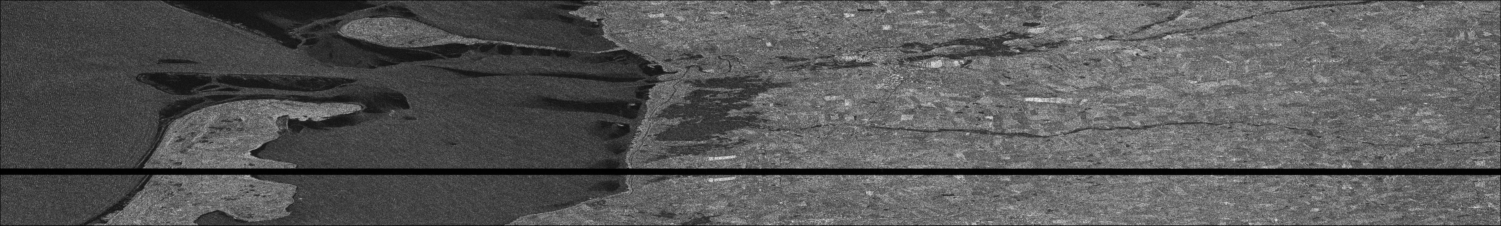

In [26]:
SlcUtil.show_img(slave_data)

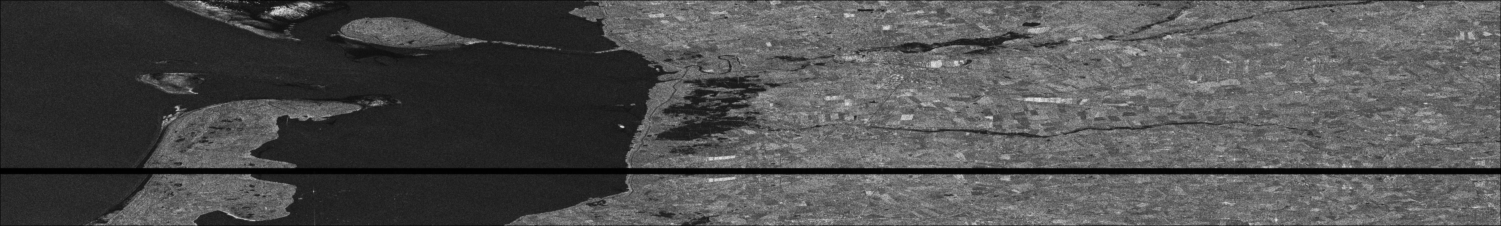

In [27]:
master_data = Load.slc_data(file_paths[index[1]][1],master_view);
SlcUtil.show_img(master_data)

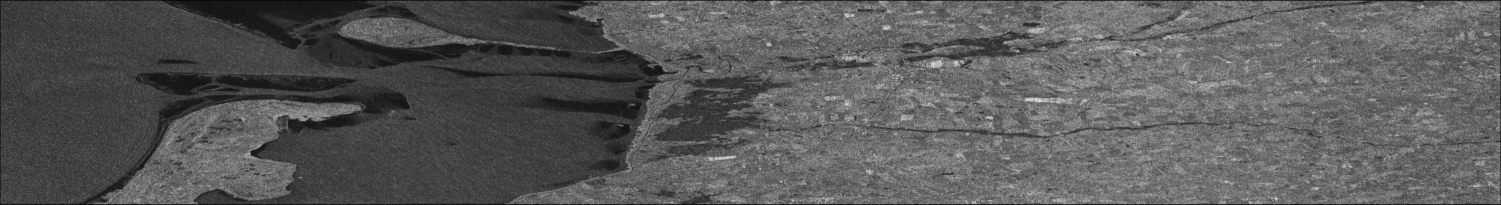

In [28]:
slave_data,mosaic_view = SlcUtil.mosaic(slave_data,master_view,meta[index[1]]);
SlcUtil.show_img(slave_data)

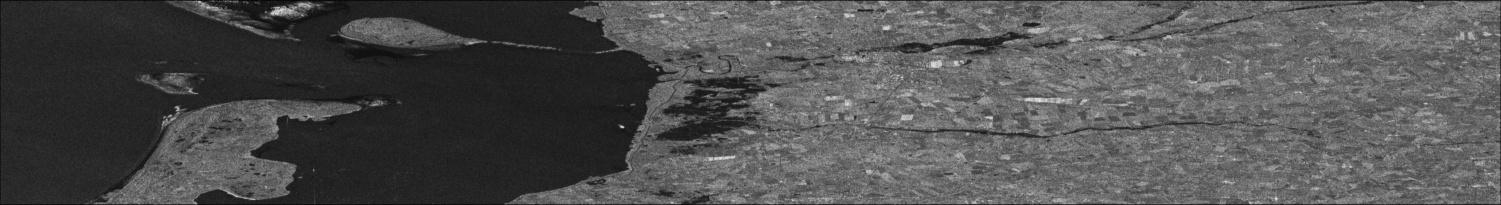

In [29]:
master_data,mosaic_view = SlcUtil.mosaic(master_data,master_view,meta[index[1]]);
SlcUtil.show_img(master_data)